In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [ ]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import torch

import meshio
import trimesh
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

In [23]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
ds.load_metadata()
pprint(ds)

ShapeNetDataset()
├── root:     PosixPath('../../data/ShapeNetSem')
└── metadata: DataFrame(shape=(12288, 16))
    ├── 'fullId':          Series(len=12288, dtype=object)
    ├── 'category':        Series(len=12288, dtype=object)
    ├── 'wnsynset':        Series(len=12288, dtype=object)
    ├── 'wnlemmas':        Series(len=12288, dtype=object)
    ├── 'up':              Series(len=12288, dtype=object)
    ├── 'front':           Series(len=12288, dtype=object)
    ├── 'unit':            Series(len=12288, dtype=float64)
    ├── 'aligned.dims':    Series(len=12288, dtype=object)
    ├── 'isContainerLike': Series(len=12288, dtype=float64)
    ├── 'surfaceVolume':   Series(len=12288, dtype=float64)
    └── <6 more items>


In [64]:
%autoreload
examples = list(ds.examples(variant='TEST'))
pprint(examples, 0)

list(len=12288)


In [65]:
%autoreload
ex = examples[2]
pprint(ex, 2)

Example()
├── dataset:      'ShapeNet'
├── subject:      'wss.101354f9d8dede686f7b08d9de913afe'
├── variant:      'TEST'
├── visit:        None
├── fixed_state:  None
├── moving_state: None
├── paths:        dict(len=6)
|   ├── 'source_mesh': PosixPath('../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj')
|   ├── 'source_mask': PosixPath('../../data/ShapeNetSem/models-binvox-solid/101354f9d8dede686f7b08d9de913afe.binvox')
|   ├── 'object_mesh': PosixPath('../../data/ShapeNetSem/TEST/meshes/101354f9d8dede686f7b08d9de913afe_object.xdmf')
|   ├── 'binary_mask': PosixPath('../../data/ShapeNetSem/TEST/masks/101354f9d8dede686f7b08d9de913afe_binary.nii.gz')
|   ├── 'region_mask': PosixPath('../../data/ShapeNetSem/TEST/masks/101354f9d8dede686f7b08d9de913afe_regions.nii.gz')
|   └── 'volume_mesh': PosixPath('../../data/ShapeNetSem/TEST/meshes/101354f9d8dede686f7b08d9de913afe_volume.xdmf')
└── metadata:     dict(len=15)
    ├── 'category':        'Speaker,_Attributes'


In [26]:
def parse_aligned_dims(s: str) -> np.ndarray:
    parts = s.replace('\\,', ',').split(',')
    return np.array([float(p) for p in parts])

# spatial metadata
dims = parse_aligned_dims(ex.metadata['aligned.dims'])
unit = ex.metadata['unit']
dims, unit

(array([43.43313 , 60.591843, 32.17259 ]), np.float64(0.0136197560186615))

# Visualize object mesh

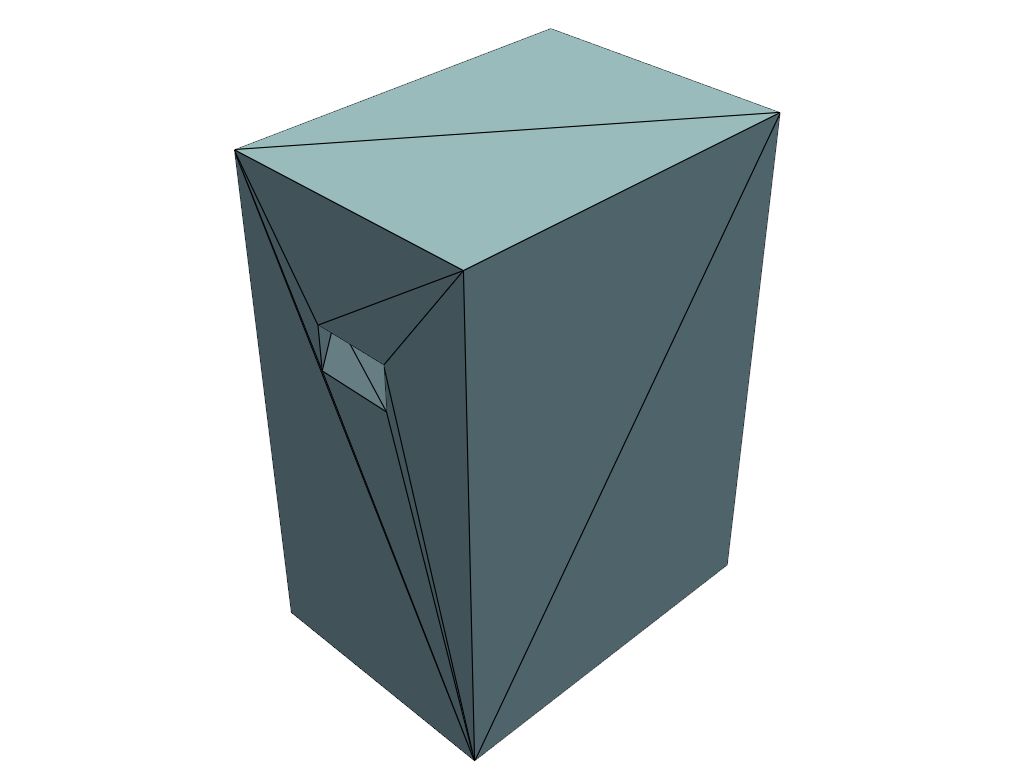

In [28]:
import meshio
raw_mesh = meshio.read(ex.paths['source_mesh'])

p = pv.Plotter()
pv_mesh = pv.wrap(raw_mesh)
pv_mesh.set_active_scalars(None)
p.add_mesh(pv_mesh, show_edges=True)
p.show(jupyter_backend='static')

# Preprocess binary mask

In [29]:
from binvox import Binvox
binvox = Binvox.read(ex.paths['source_mask'], mode='dense')
pprint(binvox)

Binvox()
├── data:       ndarray(shape=(128, 128, 128), dtype=bool)
|   ├── 0: ndarray(shape=(128, 128), dtype=bool)
|   ├── 1: ndarray(shape=(128, 128), dtype=bool)
|   ├── 2: ndarray(shape=(128, 128), dtype=bool)
|   ├── 3: ndarray(shape=(128, 128), dtype=bool)
|   ├── 4: ndarray(shape=(128, 128), dtype=bool)
|   ├── 5: ndarray(shape=(128, 128), dtype=bool)
|   ├── 6: ndarray(shape=(128, 128), dtype=bool)
|   ├── 7: ndarray(shape=(128, 128), dtype=bool)
|   ├── 8: ndarray(shape=(128, 128), dtype=bool)
|   ├── 9: ndarray(shape=(128, 128), dtype=bool)
|   └── <118 more items>
├── dims:       list(len=3)
|   ├── 0: 128
|   ├── 1: 128
|   └── 2: 128
├── translate:  list(len=3)
|   ├── 0: -0.0
|   ├── 1: 0.393701
|   └── 2: -0.0
├── scale:      0.0224779
├── axis_order: 'xyz'
└── mode:       'dense'


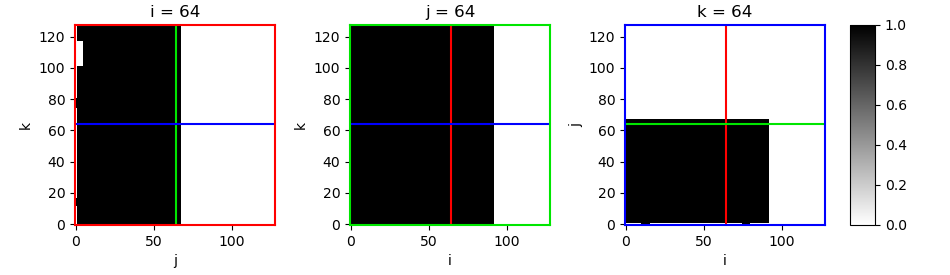

In [30]:
raw_mask = binvox.numpy().astype(np.uint8)

fig = project.visual.matplotlib.show_image_slices(raw_mask, cmap='binary', clim=(0, 1))

Input 1-connected components: 4
  Voxel counts:   [780380      1      1      1] 780383
Output 1-connected components: 1
  Voxels dropped: 3 (0.0004%)
Input 1-connected components: 15
  Voxel counts:   [1312852    3823      83       3       1       1       1       1       1
       1       1       1       1       1       1] 1316772
Output 1-connected components: 3
  Voxels dropped: 14 (0.0011%)


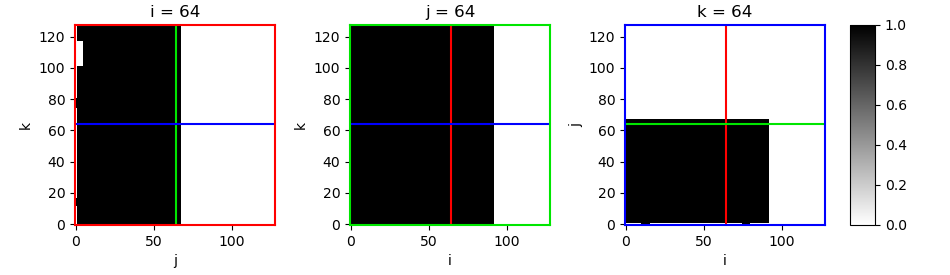

In [31]:
%autoreload
def preprocess_binary_mask(m, verbose=True):
    import project.preprocessing as pp
    m = pp.segmentation.filter_connected_components(m != 0, max_components=1, verbose=verbose)
    m = pp.segmentation.filter_connected_components(m == 0, verbose=verbose) == 0
    return m

bin_mask = preprocess_binary_mask(raw_mask)

fig = project.visual.matplotlib.show_image_slices(bin_mask, cmap='binary', clim=(0,1))

# Infer voxel-to-model affine

In [32]:
def infer_binvox_affine(bv, points, verbose=True):
    bv_shape = np.asarray(bv.dims)
    bv_trans = np.asarray(bv.translate)
    bv_scale = float(bv.scale)

    bbox = compute_bbox(points)
    s = infer_sign(bv_trans, bbox[0])
    p = infer_power(bv_scale, bbox[1].max())
    if verbose:
        print(s, p)

    spacing = bv_scale ** p / bv_shape
    origin  = bv_trans * s + spacing / 2.
    if verbose:
        print(origin, spacing)

    affine = build_affine_matrix(origin, spacing)
    if verbose:
        print(affine)

    return affine

def compute_bbox(points):
    bbox_min = points.min(axis=0)
    bbox_max = points.max(axis=0)
    bbox_extent = bbox_max - bbox_min
    return bbox_min, bbox_extent

def infer_sign(a, b, tol=1e-3):
    e_pos = relative_error(a, +b)
    e_neg = relative_error(a, -b)
    if min(e_pos, e_neg) < tol:
        return -1 if e_neg < e_pos else +1

def infer_power(a, b, tol=1e-3):
    e_eq  = relative_error(a, b)
    e_inv = relative_error(a * b, 1)
    if min(e_eq, e_inv) < tol:
        return -1 if e_inv < e_eq else +1

def relative_error(a, b, eps=1e-12):
    from numpy.linalg import norm
    return norm(a - b) / (norm(b) + eps)

def build_affine_matrix(origin, spacing):
    ox, oy, oz = origin
    sx, sy, sz = spacing
    return np.array([
        [sx, 0., 0., ox],
        [0., sy, 0., oy],
        [0., 0., sz, oz],
        [0., 0., 0., 1.],
    ], dtype=float)

affine = infer_binvox_affine(binvox, raw_mesh.points)

-1 -1
[ 0.1737818 -0.2199192  0.1737818] [0.34756361 0.34756361 0.34756361]
[[ 0.34756361  0.          0.          0.1737818 ]
 [ 0.          0.34756361  0.         -0.2199192 ]
 [ 0.          0.          0.34756361  0.1737818 ]
 [ 0.          0.          0.          1.        ]]


ndarray(shape=(128, 128, 128), dtype=bool)
ndarray(shape=(144, 144, 144), dtype=bool)


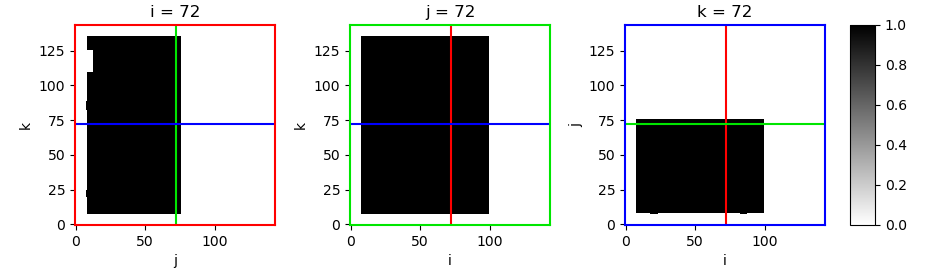

In [33]:
%autoreload
def pad_binary_mask_and_affine(input_mask, affine, pad=1):
    output_mask = np.pad(input_mask, pad, mode='constant', constant_values=0)
    origin = np.array(affine[:3,3])
    spacing = np.diag(affine[:3,:3])
    affine = build_affine_matrix(origin - pad * spacing, spacing)
    return output_mask, affine

pprint(bin_mask, 0)
padded_mask, padded_affine = pad_binary_mask_and_affine(bin_mask, affine, pad=8)
pprint(padded_mask, 0)

fig = project.visual.matplotlib.show_image_slices(padded_mask, cmap='binary', clim=(0, 1))

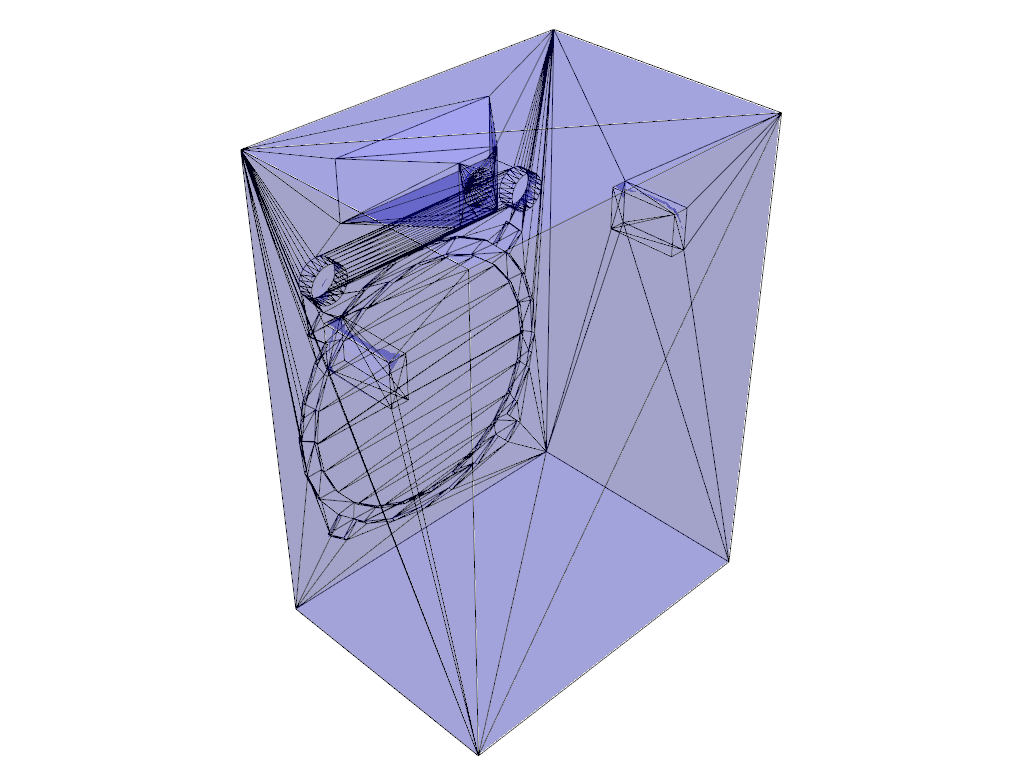

In [34]:
# check affine alignment
def as_pyvista_grid(affine, **arrays):
    grid = pv.ImageData(
        dimensions=next(iter(arrays.values())).shape,
        spacing=np.linalg.norm(affine[:3,:3], axis=1),
        origin=affine[:3,3]
    )
    for k, v in arrays.items():
        grid.point_data[k] = v.flatten(order='F').astype(float)
    return grid

pv_grid = as_pyvista_grid(padded_affine, mask=padded_mask)
pv_iso = pv_grid.contour(0.5, scalars='mask')

p = pv.Plotter()
p.add_mesh(pv_iso, color='blue', opacity=0.2)
p.add_mesh(pv_mesh, color='black', style='wireframe', show_scalar_bar=False)
p.enable_depth_peeling(10)
p.show(jupyter_backend='static')

In [54]:
# save binary mask
import nibabel as nib
bin_nifti = nib.nifti1.Nifti1Image(bin_mask.astype(np.uint8), affine)
ex.paths['binary_mask'].parent.mkdir(parents=True, exist_ok=True)
nib.save(bin_nifti, ex.paths['binary_mask'])

# Preprocess surface mesh

In [66]:
import trimesh

class ShapeNetResolver(trimesh.resolvers.Resolver):
    '''
    Trimesh path resolver for ShapeNet dataset.
    '''
    def __init__(self, data_root):
        import pathlib
        self.root = pathlib.Path(data_root)
        self.obj_root = self.root / 'models-OBJ' / 'models'
        self.tex_root = self.root / 'models-textures' / 'textures'

    def get_path(self, name):
        name = str(name).strip().replace('\\', '/').lstrip('/')
        ext = os.path.splitext(name)[1].lower()
        if ext in {'.obj', '.mtl'}:
            return self.obj_root / name
        elif ext in {'.jpg', '.jpeg', '.png'}:
            return self.tex_root / name
        else:
            return name

    def get(self, name):
        print('get', name)
        path = self.get_path(name)
        data = path.read_bytes()
        return data

    def write(self, name, data):
        print('write', name, data)
        raise NotImplementedError

    def namespaced(self, namespace):
        print('namespaced', namespace)
        raise NotImplementedError

    def keys(self):
        print('keys')
        raise NotImplementedError

scene = trimesh.load_scene(
    ex.paths['source_mesh'],
    resolver=ShapeNetResolver(ds.root),
    group_material=True,
    skip_materials=False,
    process=False
)
pprint(scene)

get 101354f9d8dede686f7b08d9de913afe.mtl
get 007749519811e17c.jpg
Scene()
├── geometry: OrderedDict(len=7)
|   ├── 'm5': Trimesh()
|   ├── 'm2': Trimesh()
|   ├── 'm3': Trimesh()
|   ├── 'm6': Trimesh()
|   ├── 'm1': Trimesh()
|   ├── 'm0': Trimesh()
|   └── 'm4': Trimesh()
├── graph:    SceneGraph()
|   ├── transforms:   EnforcedForest()
|   ├── base_frame:   'world'
|   └── repair_rigid: 1e-05
└── metadata: dict(len=0)


In [67]:
def get_mesh_info(mesh):
    vertices, faces = mesh.vertices, mesh.faces
    num_components = len(mesh.split(only_watertight=False))
    angles = np.degrees(trimesh.triangles.angles(mesh.triangles))
    return dict(
        vertices=len(vertices),
        faces=len(faces),
        edges=count_edge_types(faces),
        euler_number=mesh.euler_number,
        watertight=mesh.is_watertight,
        components=num_components,
        angles=dict(
            min=float(angles.min()),
            p05=float(np.percentile(angles, 5)),
            p50=float(np.percentile(angles, 50)),
            p95=float(np.percentile(angles, 95)),
            max=float(angles.max()),
        ),

    )

def count_edge_types(faces):
    u, c = count_unique_edges(faces)
    n1 = int((c == 1).sum())
    n2 = int((c == 2).sum())
    nm = int((c >= 3).sum())
    return dict(boundary=n1, interior=n2, nonmanifold=nm)

def count_unique_edges(faces):
    f = faces.astype(np.int32, copy=False)
    e = np.vstack([f[:,[0,1]], f[:,[1,2]], f[:,[2,0]]])
    e.sort(axis=1)
    return np.unique(e, axis=0, return_counts=True)

raw_mesh = scene.to_mesh()
pprint(get_mesh_info(raw_mesh))

dict(len=7)
├── 'vertices':     3372
├── 'faces':        1124
├── 'edges':        dict(len=3)
|   ├── 'boundary':    3372
|   ├── 'interior':    0
|   └── 'nonmanifold': 0
├── 'euler_number': 1124
├── 'watertight':   False
├── 'components':   1124
└── 'angles':       dict(len=5)
    ├── 'min': 2.1721067939229608e-05
    ├── 'p05': 2.4826051660825077
    ├── 'p50': 73.4018487958215
    ├── 'p95': 146.24747013993058
    └── 'max': 179.99995146989576


In [68]:
import pymeshfix
import point_cloud_utils

def preprocess_triangle_mesh(mesh, verbose=True):

    m = mesh.copy()
    m.remove_unreferenced_vertices()
    m.merge_vertices(digits_vertex=8, merge_norm=True, merge_tex=True)
    m.update_faces(m.nondegenerate_faces())
    m.update_faces(m.unique_faces())
    trimesh.repair.fill_holes(m)

    mesh_fixer = pymeshfix.MeshFix(m.vertices, m.faces)
    mesh_fixer.repair(verbose=True)
    m = trimesh.Trimesh(vertices=mesh_fixer.v, faces=mesh_fixer.f, process=False)

    trimesh.repair.fix_normals(m)
    return m

tri_mesh = preprocess_triangle_mesh(raw_mesh)
pprint(get_mesh_info(tri_mesh))

Removed 3 small componentsINFO- Loaded 292 vertices and 562 faces.

Patching holes...
Patched 2 holes
Fixing degeneracies and intersections

100% done 
INFO- ********* ITERATION 0 *********
INFO- Removing degeneracies...
INFO- Removing self-intersections...

0 % done   
INFO- 18 intersecting triangles have been selected.

0 % done   
INFO- No intersections detected.
dict(len=7)
├── 'vertices':     310
├── 'faces':        616
├── 'edges':        dict(len=3)
|   ├── 'boundary':    0
|   ├── 'interior':    924
|   └── 'nonmanifold': 0
├── 'euler_number': 2
├── 'watertight':   True
├── 'components':   1
└── 'angles':       dict(len=5)
    ├── 'min': 2.9153588559787306e-05
    ├── 'p05': 3.3738954464765927
    ├── 'p50': 67.62282175070766
    ├── 'p95': 148.6860654651519
    └── 'max': 179.9999349169072


WARNING- Some cuts were necessary to cope with non manifold configuration.


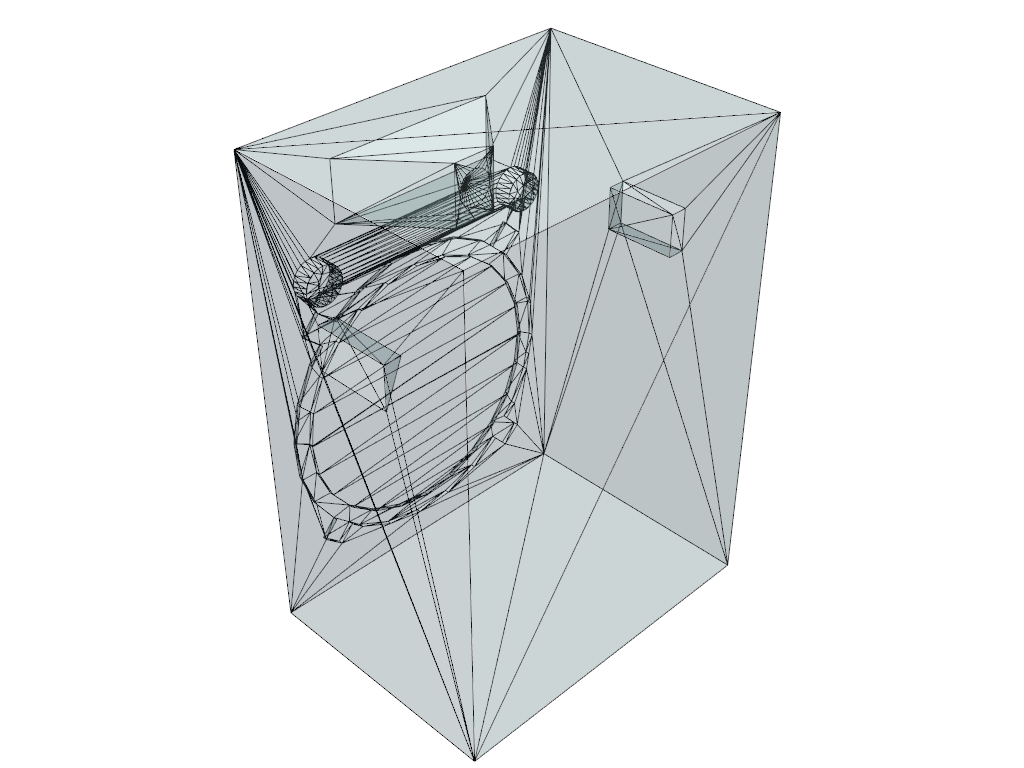

In [69]:
p = pv.Plotter()
pv_mesh = pv.wrap(tri_mesh)
p.add_mesh(pv_mesh, color='lightblue', opacity=0.2)
p.add_mesh(pv_mesh, style='wireframe', color='black')
p.enable_depth_peeling(10)
p.show(jupyter_backend='static')

In [70]:
# save watertight mesh
object_mesh = meshio.Mesh(
    points=tri_mesh.vertices,
    cells=[('triangle', tri_mesh.faces)]
)
ex.paths['object_mesh'].parent.mkdir(parents=True, exist_ok=True)

meshio.xdmf.write(ex.paths['object_mesh'], object_mesh)

In [67]:
import pygalmesh

h = float(np.linalg.norm(affine[:3,:3], axis=1).min())
print(h)

vol_mesh = pygalmesh.generate_volume_mesh_from_surface_mesh(
    temp_path,
    max_cell_circumradius=5.0 * h,
    max_facet_distance=0.5 * h,
    min_facet_angle=25,
    lloyd=True,
    odt=True,
    seed=0
)
vol_mesh

0.34756360692057536


<meshio mesh object>
  Number of points: 7156
  Number of cells:
    triangle: 14784
    tetra: 31127
  Point data: medit:ref
  Cell data: medit:ref

In [69]:
p = pv.Plotter()
pv_mesh = pv.wrap(vol_mesh)
p.add_mesh(pv_mesh, color='lightblue', opacity=1.0, show_edges=True)
p.add_mesh(pv_mesh, style='wireframe', color='black')
p.enable_depth_peeling(10)
p.show(jupyter_backend='trame')

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x148b516e2a10_15" src="https://ondemand.bridges2.…

# Assign region labels

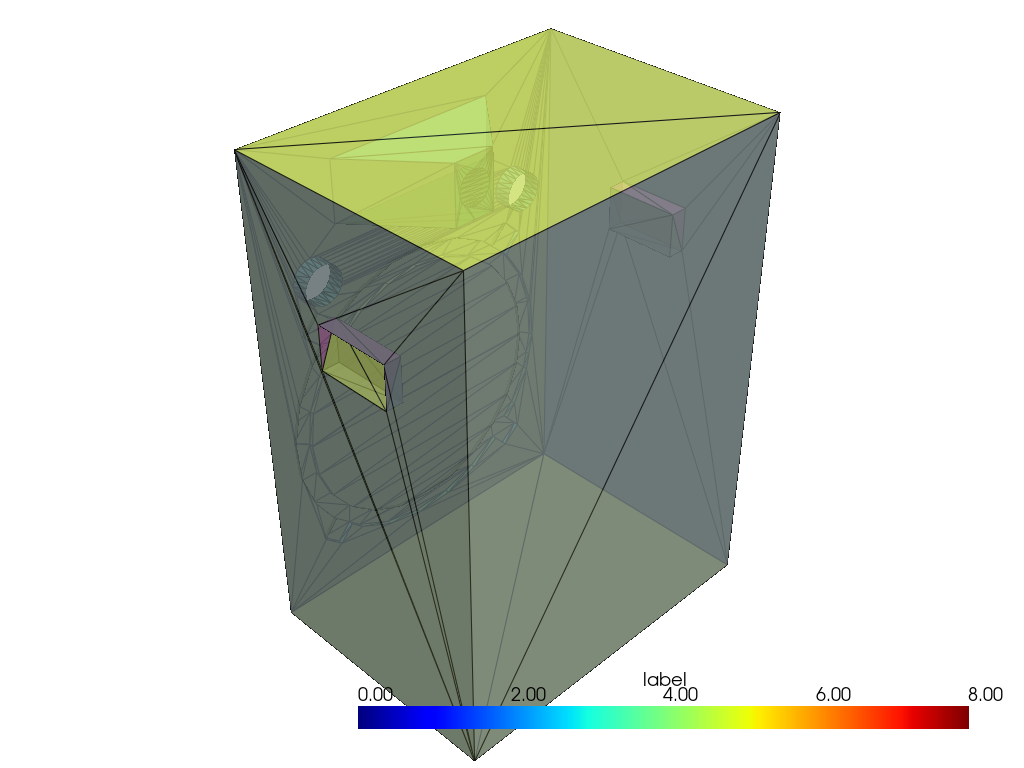

In [75]:
def extract_mesh_labels(scene):

    # when trimesh loads an obj file with materials,
    # it groups the faces assigned to each material
    # into separate geometries in a scene object.

    # here we merge the geometries into a single mesh,
    # but label the faces based on the material group.

    verts, faces, labels = [], [], []
    offset = 0

    for idx, name in enumerate(scene.graph.nodes_geometry):
        geom = scene.geometry[name]
    
        T = scene.graph[name][0]
        if not np.allclose(T, np.eye(4)):
            print(f'WARNING: Non-identity transform on {name}:\n{T}', file=sys.stderr)
    
        v = trimesh.transform_points(geom.vertices, T)
        f = geom.faces

        verts.append(v.copy())
        faces.append(f.copy() + offset)
        labels.append(np.full(len(f), idx, dtype=int))
        offset += len(v)

    if not verts:
        raise ValueError('scene has no geometries')

    verts  = np.concatenate(verts, axis=0)
    faces  = np.concatenate(faces, axis=0)
    labels = np.concatenate(labels, axis=0)

    mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=False)
    return mesh, labels

raw_mesh, labels = extract_mesh_labels(scene)

pv_mesh = pv.wrap(raw_mesh)
pv_mesh.cell_data['label'] = labels

p = pv.Plotter()
p.add_mesh(pv_mesh, scalars='label', cmap='jet', clim=(0, 8), opacity=0.8, show_edges=True)
p.enable_depth_peeling(10)
p.show(jupyter_backend='static')

100%|██████████| 1/1 [00:00<00:00, 15.22it/s]


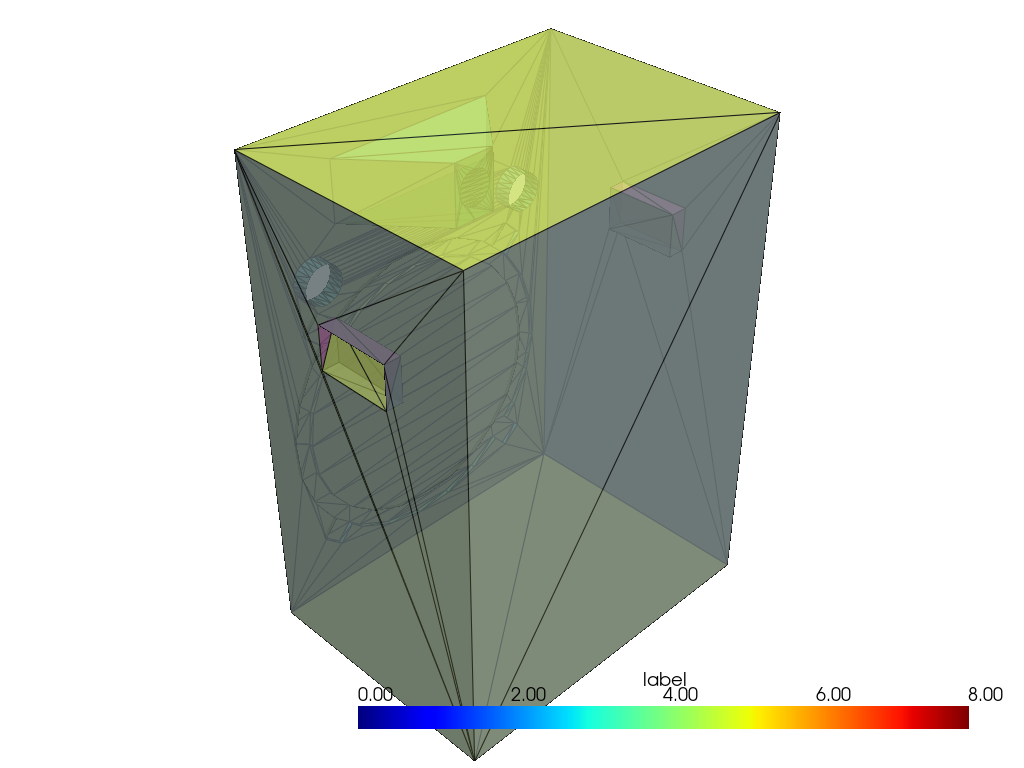

In [76]:
import tqdm

def query_mesh_labels(mesh, labels, points, batch_size=10000):
    assert points.ndim == 2 and points.shape[1] == 3

    query = trimesh.proximity.ProximityQuery(mesh)
    points = np.asarray(points, dtype=np.float32)
    output = np.empty(len(points), dtype=int)
    
    for start in tqdm.tqdm(range(0, len(points), batch_size), file=sys.stderr):
        end = min(start + batch_size, len(points))
        _, _, face_inds = query.on_surface(points[start:end])
        output[start:end] = labels[face_inds]
    
    return output

triangles = raw_mesh.triangles
points = triangles.mean(axis=1)
normals, valid = trimesh.triangles.normals(triangles)
points[valid] += normals * 1e-3
    
new_labels = query_mesh_labels(raw_mesh, labels, points)

pv_mesh = pv.wrap(raw_mesh)
pv_mesh.cell_data['label'] = new_labels

p = pv.Plotter()
p.add_mesh(pv_mesh, scalars='label', cmap='jet', clim=(0, 8), opacity=0.8, show_edges=True)
p.enable_depth_peeling(10)
p.show(jupyter_backend='static')

100%|██████████| 79/79 [01:20<00:00,  1.02s/it]

CPU times: user 1min 19s, sys: 1.55 s, total: 1min 20s
Wall time: 1min 20s


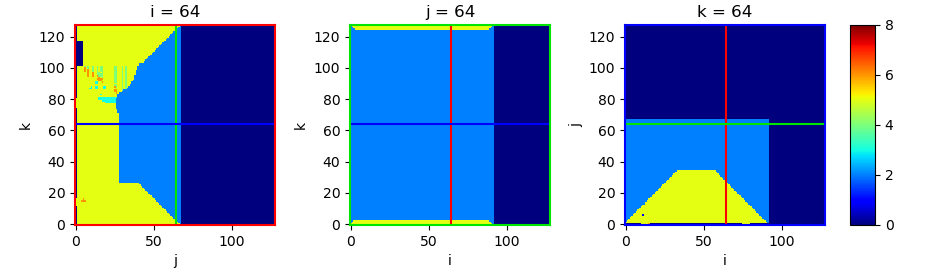

In [58]:
%%time
def assign_voxel_labels(input_mask, affine, mesh, labels):

    I, J, K = np.nonzero(input_mask)
    points_voxel = np.c_[I, J, K]
    points_model = project.core.transforms.voxel_to_world_coords(points_voxel, affine)

    label_mask = np.zeros_like(input_mask, dtype=np.int32) # background = 0
    label_mask[I, J, K] = query_mesh_labels(mesh, labels, points_model) + 1
    return label_mask

region_mask = assign_voxel_labels(bin_mask, affine, raw_mesh, labels)

fig = project.visual.matplotlib.show_image_slices(region_mask, cmap='jet', clim=(0, 8))

In [59]:
%autoreload
import scipy

def cleanup_region_mask(input_mask, min_count=1000):
    output_mask = np.zeros_like(input_mask)

    # filter connected components in each region
    for l in np.unique(input_mask[input_mask != 0]):
        print(f'Filtering region {l}')
        m = project.preprocessing.segmentation.filter_connected_components(
            input_mask == l, min_count=min_count, keep_largest=False
        )
        output_mask[m] = l

    # reassign dropped voxels to nearest region
    dropped = (input_mask != 0) & (output_mask == 0)
    if np.any(dropped):
        _, indices = scipy.ndimage.distance_transform_edt(dropped, return_indices=True)
        nearest_labels = output_mask[tuple(indices)]
        output_mask[dropped] = nearest_labels[dropped]

    return output_mask

final_mask = cleanup_region_mask(region_mask)

Filtering region 1
Input 1-connected components: 82
  Voxel counts:   [20 20 18 17 15 15 14 12 12 11 11 11 11  9  9  8  8  7  7  6  6  5  5  4
  4  4  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1] 349
Output 1-connected components: 0
  Voxels dropped: 349 (100.0000%)
Filtering region 2
Input 1-connected components: 3
  Voxel counts:   [421450      1      1] 421452
Output 1-connected components: 1
  Voxels dropped: 2 (0.0005%)
Filtering region 3
Input 1-connected components: 131
  Voxel counts:   [1279 1138  233  134   24   23   22   21   17   17   15   14   13   11
   11   10   10    9    9    7    6    6    6    6    5    5    5    5
    4    4    4    4    4    4    4    4    3    3    3    3    3    3
    3    3    3    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2    2    2    2    2    2    2    2    2    2    2
    2    2    2    2

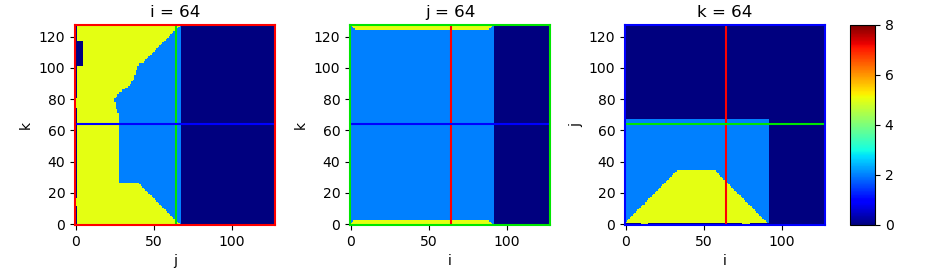

In [60]:
fig = project.visual.matplotlib.show_image_slices(final_mask, cmap='jet', clim=(0, 8))

In [61]:
unique, counts = np.unique(final_mask, return_counts=True)
print(unique)
print(counts)

opacity = np.zeros(max(9, unique.max()))
opacity[unique] = np.minimum(10000 / counts, 1.0)
opacity[0] = 0
print(len(opacity))

print(opacity)

[0 2 3 5]
[1317613  423481    2417  353641]
9
[0.         0.         0.02361381 1.         0.         0.02827726
 0.         0.         0.        ]


In [62]:
pv_grid = as_pyvista_grid(affine, label=final_mask)

p = pv.Plotter()
p.add_volume(pv_grid, scalars='label', cmap='jet', clim=(0, 8), opacity=opacity)
p.add_mesh(pv.wrap(tri_mesh), style='wireframe', color='black')
p.enable_depth_peeling(10)
p.show(jupyter_backend='trame')

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x152f2cd7e5d0_6" src="https://ondemand.bridges2.p…

In [77]:
# save region mask
import nibabel as nib
region_nifti = nib.nifti1.Nifti1Image(final_mask.astype(np.int16), affine)
ex.paths['region_mask'].parent.mkdir(parents=True, exist_ok=True)
nib.save(bin_nifti, ex.paths['region_mask'])

# Generate volume mesh from region mask

In [81]:
import pygalmesh

spacing = np.linalg.norm(affine[:3,:3], axis=1)
h = float(spacing.min())
print(h)

mesh_dict = project.preprocessing.meshing.generate_mesh_from_mask(
    final_mask,
    resolution=spacing,
    pygalmesh_kws=dict(
        max_cell_circumradius=5.0 * h,
        max_facet_distance=0.5 * h,
        min_facet_angle=20,
        lloyd=True,
        odt=True,
        seed=0
    )
)
vol_mesh = mesh_dict['tetra']
surf_mesh = mesh_dict['triangle']

vol_mesh

0.34756360692057536
Removed 0 unused points
Final mesh:  <meshio mesh object>
  Number of points: 8572
  Number of cells:
    triangle: 24756
    tetra: 38974
  Cell data: label
Mesh has 1 connected component(s)


<meshio mesh object>
  Number of points: 8572
  Number of cells:
    tetra: 38974
  Cell data: label

In [82]:
p = pv.Plotter()
pv_mesh = pv.wrap(vol_mesh)
p.add_mesh(pv_mesh, scalars='label', cmap='jet', clim=(0, 8), opacity=0.5, show_edges=True)
p.add_mesh(pv_mesh, style='wireframe', color='black')
p.enable_depth_peeling(10)
p.show(jupyter_backend='trame')

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x152f2f082790_13" src="https://ondemand.bridges2.…

In [83]:
# save volume mesh
ex.paths['volume_mesh'].parent.mkdir(parents=True, exist_ok=True)
meshio.xdmf.write(ex.paths['volume_mesh'], vol_mesh)

# Assign material properties and textures

In [97]:
density_values = {'Dense': 500.0, 'Porous': 50.0}          # kg/m^3
elastic_values = {'Soft': 1.0, 'Medium': 3.0, 'Hard': 9.0} # kPa

density_freqs = {'Dense': 0.75, 'Porous': 0.25}
elastic_freqs = {'Soft': 0.25, 'Medium': 0.5, 'Hard': 0.25}

props = pd.DataFrame(columns=['Material', 'DensityKgm3', 'YoungsModulusPa', 'PoissonRatio', 'Frequency'])
props.set_index('Material', inplace=True)
props.loc['Background', :] = 0

for i, d in enumerate(density_values):
    for j, e in enumerate(elastic_values):
        material = f'{d}{e}'
        props.loc[material, 'DensityKgm3']     = density_values[d]
        props.loc[material, 'YoungsModulusPa'] = elastic_values[e] * 1e3 # kPa -> Pa
        props.loc[material, 'PoissonRatio']    = 0.4
        props.loc[material, 'Frequency']       = density_freqs[d] * elastic_freqs[e]

props['Frequency'] /= props['Frequency'].sum()
props.reset_index(inplace=True)
props

Material DensityKgm3 YoungsModulusPa PoissonRatio Frequency
0    Background           0               0            0       0.0
1     DenseSoft       500.0          1000.0          0.4    0.1875
2   DenseMedium       500.0          3000.0          0.4     0.375
3     DenseHard       500.0          9000.0          0.4    0.1875
4    PorousSoft        50.0          1000.0          0.4    0.0625
5  PorousMedium        50.0          3000.0          0.4     0.125
6    PorousHard        50.0          9000.0          0.4    0.0625

In [103]:
import skimage

def assign_materials_to_regions(region_mask, prior, vote_rate=1e-3, min_votes=1, seed=0):
    '''
    Assign materials to a multi-label region mask by sampling
    votes from a prior distribution over the materials.

    Iterate over the labeled regions from largest to smallest,
    sampling votes from the prior in proportion to region size.
    Select the top-ranked material not already assigned to a
    neighboring region.

    Args:
        region_mask: (I, J, K) int array of region labels
        prior: (M,) float array of material probabilities
        vote_rate: number of votes per voxel (default: 1e-3)
        min_votes: minimum votes per region (default: 1)
        seed: random seed
    Returns:
        material_map: (N,) int array mapping region labels
            to material indices, with -1 for not assigned
    '''
    rng = np.random.default_rng(seed)

    # compute region sizes and drop background
    regions, sizes = np.unique(region_mask, return_counts=True)
    regions, sizes = regions[regions > 0], sizes[regions > 0]
    size_order = np.argsort(-sizes)

    # build region adjacency graph
    g = skimage.graph.rag_boundary(
        region_mask.astype(int),
        edge_map=np.ones_like(region_mask, dtype=float),
        connectivity=3
    )
    adjacent = {int(n): {int(nb) for nb in g.neighbors(n)} for n in g.nodes}

    # prior distribution over materials
    prior = np.asarray(prior, dtype=float)
    prior /= prior.sum()
    n_materials = len(prior)

    assigned = {}
    for idx in size_order:
        region, size = int(regions[idx]), int(sizes[idx])

        # sample votes from prior distribution
        n_votes = max(min_votes, int(vote_rate * size))
        votes = rng.multinomial(n_votes, prior)

        # apply slight jitter to break ties
        jitter = rng.uniform(-0.1, 0.1, size=n_materials)
        ranked_by_votes = np.argsort(-(votes + jitter))

        neighbors = {assigned.get(nb) for nb in adjacent.get(region, [])}
        neighbors.discard(None)

        choice = None
        for candidate in ranked_by_votes:
            if candidate not in neighbors:
                choice = candidate
                break

        if choice is None: # cannot avoid a conflict
            print(f'WARNING: adjacent regions share a material', file=sys.stderr)
            choice = ranked_by_votes[0]

        assigned[region] = int(choice)

    max_region = int(regions.max())
    material_map = -np.ones(max_region + 1, dtype=int)
    for r, m in assigned.items():
        material_map[r] = m

    return material_map

material_map = assign_materials_to_regions(final_mask, prior=props.iloc[1:].Frequency)
material_map

array([-1, -1,  1,  3, -1,  2])

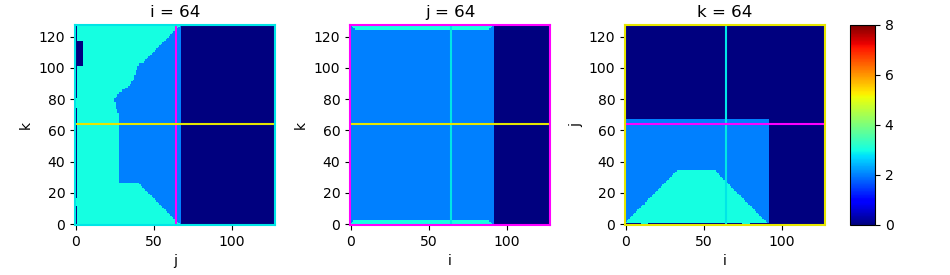

In [106]:
material_mask = (material_map + 1)[final_mask] # shift labels so background = 0

fig = project.visual.matplotlib.show_image_slices(material_mask, cmap='jet', clim=(0, 8), colors='cmy')

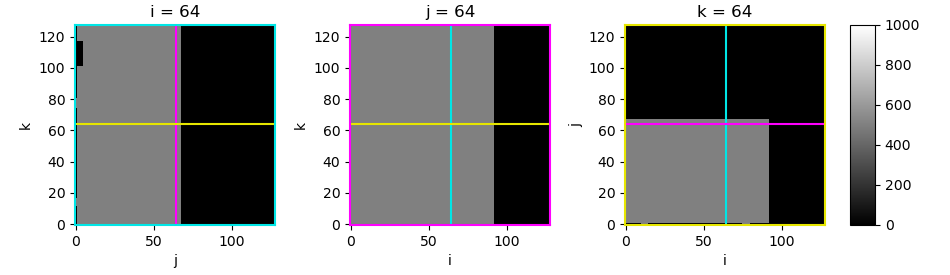

In [107]:
density_map  = np.asarray(props.DensityKgm3, dtype=float)
density_mask = density_map[material_mask]

fig = project.visual.matplotlib.show_image_slices(density_mask, cmap='binary_r', clim=(0, 1000), colors='cmy')

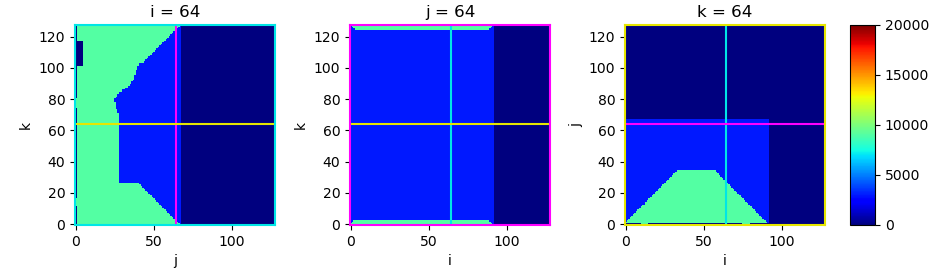

In [108]:
elast_map  = np.asarray(props.YoungsModulusPa, dtype=float)
elast_mask = elast_map[material_mask]

fig = project.visual.matplotlib.show_image_slices(elast_mask, cmap='jet', clim=(0, 2e4), colors='cmy')

# Texture classification

In [596]:
import matplotlib.pyplot as plt
import imageio

class TextureSampler:

    def __init__(self, texture_dir, seed=0, pos=0, log=None, exts=['.jpg', '.jpeg']):
        self.paths = [
            p for p in texture_dir.rglob('*') if p.suffix.lower() in exts
        ]
        if not self.paths:
            raise ValueError('No textures found')
        else:
            print(f'{len(self.paths)} textures found')
        rng = np.random.default_rng(seed)
        self.order = rng.permutation(len(self.paths)).tolist()
        self.pos = pos
        self.log = log or []

    def __len__(self):
        return len(self.paths)

    def next(self):
        if self.pos >= len(self.order):
            raise StopIteration
        idx = self.order[self.pos]
        self.pos += 1
        return idx, self.paths[idx]

    def peek(self):
        if self.pos >= len(self.order):
            raise StopIteration
        idx = self.order[self.pos]
        return idx, self.paths[idx]

    def annotate(self, idx, annotation):
        self.log.append((idx, self.paths[idx], str(annotation)))

    def save(self, path):
        import csv
        with open(path, 'w', newline='') as f:
            w = csv.writer(f)
            w.writerow(['idx', 'path', 'annotation'])
            w.writerows(self.log)


def show_texture(img, title=None):
    fig, ax = plt.subplots()
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)
    if title:
        ax.set_title(title)
    plt.axis('off')
    plt.show()

sampler = TextureSampler(ds.root / 'models-textures' / 'textures')

22984 textures found


In [1283]:
pprint(sampler, 1)

TextureSampler()
├── paths: list(len=22984)
├── order: list(len=22984)
├── pos:   1018
└── log:   list(len=115)


20938 ../../data/ShapeNetSem/models-textures/textures/957be918eccec28f.jpg (192, 348, 3)


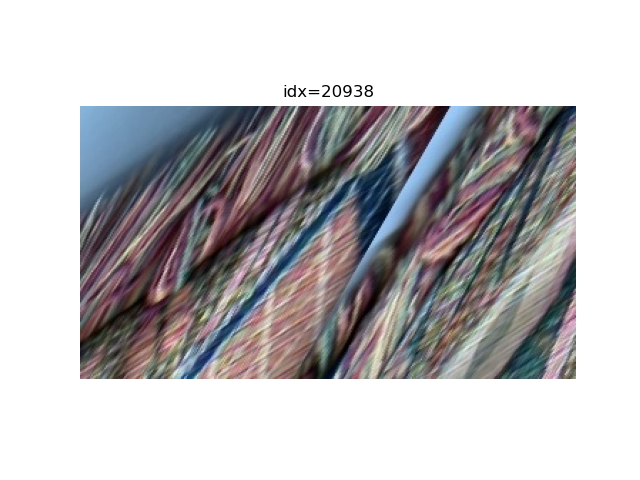

In [1286]:
size_ok = False
while not size_ok:
    idx, path = sampler.next()
    img = imageio.v2.imread(path)
    print(idx, path, img.shape, flush=True)
    if min(img.shape[:2]) >= 32:
        size_ok = True

show_texture(img, title=f'idx={idx}')

In [1261]:
sampler.annotate(idx, 'metal')

In [1289]:
sampler.save('texture_annotations_2025-10-21.csv')

In [255]:
tex = pd.read_csv('texture_annotations_2025-10-21.csv')

# manual corrections
tex.loc[[1, 76, 42], 'annotation'] = 'marble'
tex.loc[88, 'annotation'] = 'brick'
tex.loc[80, 'annotation'] = 'stone'
tex.loc[ 8, 'annotation'] = 'fiberboard'
tex.loc[[84, 90], 'annotation'] = 'grass'
tex.loc[97, 'annotation'] = 'stone'
tex.loc[ 3, 'annotation'] = 'cardboard'
tex.loc[[27, 72, 54, 89, 74, 73], 'annotation'] = 'paper'
tex.loc[[74, 100], 'annotation'] = 'fabric'
tex.loc[[34], 'annotation'] = 'stone'
tex.loc[[98, 103], 'annotation'] = 'gravel'
tex.loc[[56], 'annotation'] = 'paint'

tex.loc[:, 'is_texture'] = True
tex.loc[[32, 82, 13, 41, 113, 33, 87, 7, 28, 20, 56, 3, 77], 'is_texture'] = False

tex.loc[:, 'is_duplicate'] = False
tex.loc[[10, 12, 29, 40, 57, 60, 61, 71, 95, 80, 51, 22, 105, 59, 94, 68, 69, 109, 110, 4, 23, 24, 36, 43, 47, 62, 79, 18, 26, 76, 90, 106], 'is_duplicate'] = True

tex.loc[:, 'poor_quality'] = False
tex.loc[[5, 45, 17, 48, 67, 92, 83, 81, 53, 2, 16, 39, 88, 49], 'poor_quality'] = True

tex.loc[:, 'inverted'] = False
tex.loc[[55], 'inverted'] = True

tex

idx                                               path annotation  \
0    18231  ../../data/ShapeNetSem/models-textures/texture...     carpet   
1    17033  ../../data/ShapeNetSem/models-textures/texture...     marble   
2    18752  ../../data/ShapeNetSem/models-textures/texture...       wood   
3    17435  ../../data/ShapeNetSem/models-textures/texture...  cardboard   
4     3048  ../../data/ShapeNetSem/models-textures/texture...       wood   
..     ...                                                ...        ...   
109     42  ../../data/ShapeNetSem/models-textures/texture...       wood   
110  12807  ../../data/ShapeNetSem/models-textures/texture...       wood   
111   5066  ../../data/ShapeNetSem/models-textures/texture...       wood   
112   5531  ../../data/ShapeNetSem/models-textures/texture...    leather   
113   1626  ../../data/ShapeNetSem/models-textures/texture...      metal   

     is_texture  is_duplicate  poor_quality  inverted  
0          True         False         False     False  
1          True         False         False     False  
2          True         False          True     False  
3         False         False         False     False  
4          True          True         False     False  
..          ...           ...           ...       ...  
109        True          True         False     False  
110        True          True         False     False  
111        True         False         False     False  
112        True         False         False     False  
113       False         False         False     False  

[114 rows x 7 columns]

In [260]:
texture_types_by_material = {
    'DenseSoft':    ['paper'],
    'DenseMedium':  ['leather'],
    'DenseHard':    ['stone'],
    'PorousSoft':   ['fabric'],
    'PorousMedium': ['wood'],
    'PorousHard':   ['marble'],
}

textures_by_material = {}
for key, vals in texture_types_by_material.items():
    textures_by_material[key] = tex[
        tex.annotation.isin(vals) & tex.is_texture & ~tex.is_duplicate & ~tex.poor_quality
    ]

pprint(textures_by_material, 2)

dict(len=6)
├── 'DenseSoft':    DataFrame(shape=(5, 7))
|   ├── 'idx':          Series(len=5, dtype=int64)
|   ├── 'path':         Series(len=5, dtype=object)
|   ├── 'annotation':   Series(len=5, dtype=object)
|   ├── 'is_texture':   Series(len=5, dtype=bool)
|   ├── 'is_duplicate': Series(len=5, dtype=bool)
|   ├── 'poor_quality': Series(len=5, dtype=bool)
|   └── 'inverted':     Series(len=5, dtype=bool)
├── 'DenseMedium':  DataFrame(shape=(5, 7))
|   ├── 'idx':          Series(len=5, dtype=int64)
|   ├── 'path':         Series(len=5, dtype=object)
|   ├── 'annotation':   Series(len=5, dtype=object)
|   ├── 'is_texture':   Series(len=5, dtype=bool)
|   ├── 'is_duplicate': Series(len=5, dtype=bool)
|   ├── 'poor_quality': Series(len=5, dtype=bool)
|   └── 'inverted':     Series(len=5, dtype=bool)
├── 'DenseHard':    DataFrame(shape=(5, 7))
|   ├── 'idx':          Series(len=5, dtype=int64)
|   ├── 'path':         Series(len=5, dtype=object)
|   ├── 'annotation':   Series(len=5, dtype

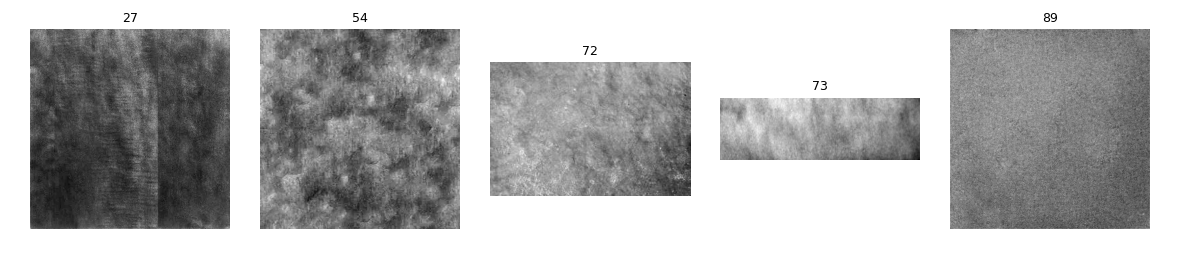

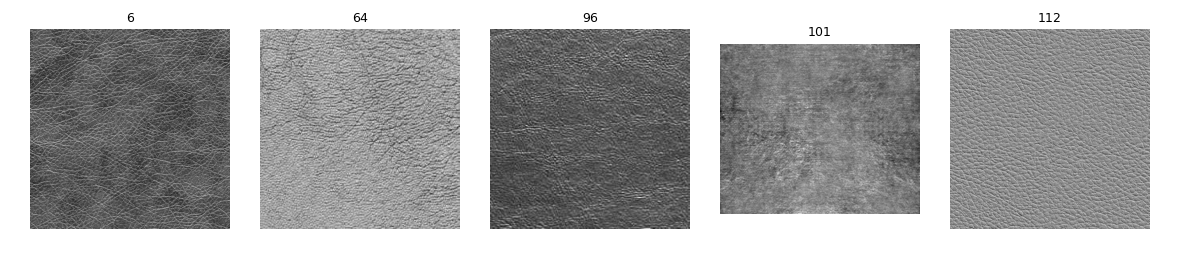

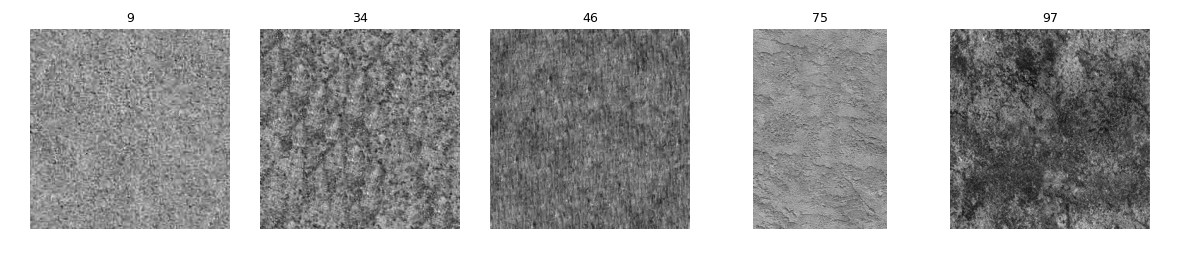

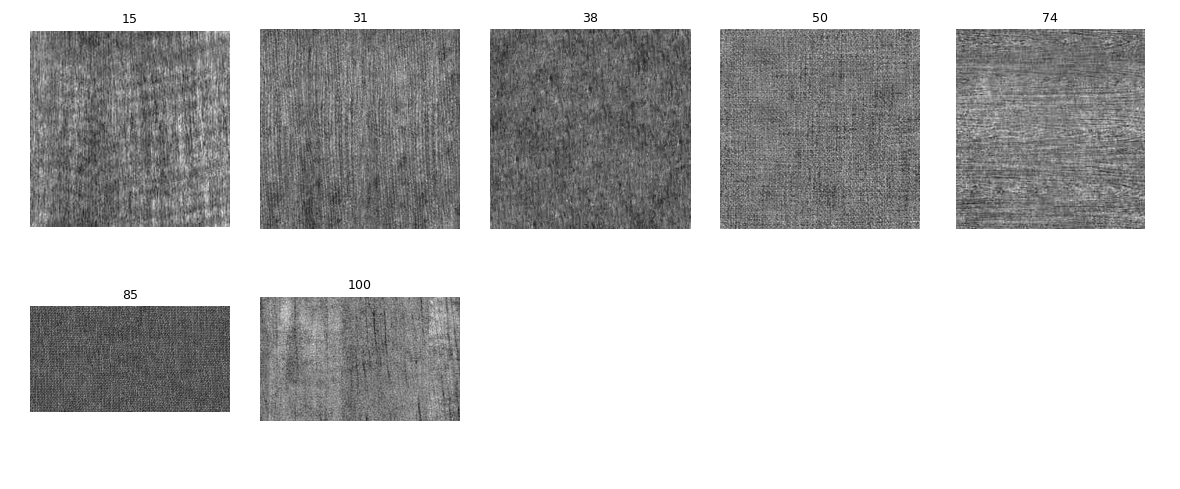

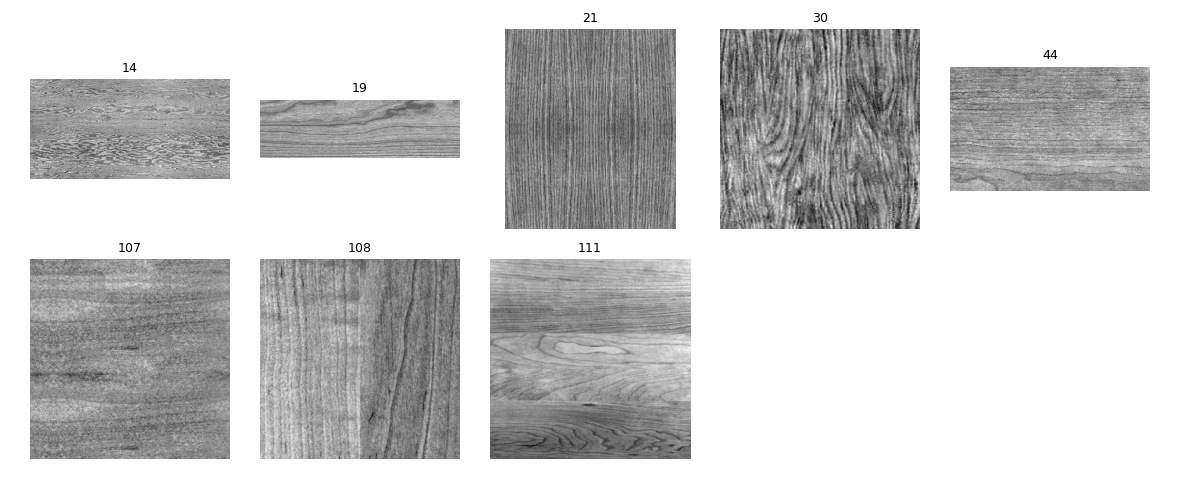

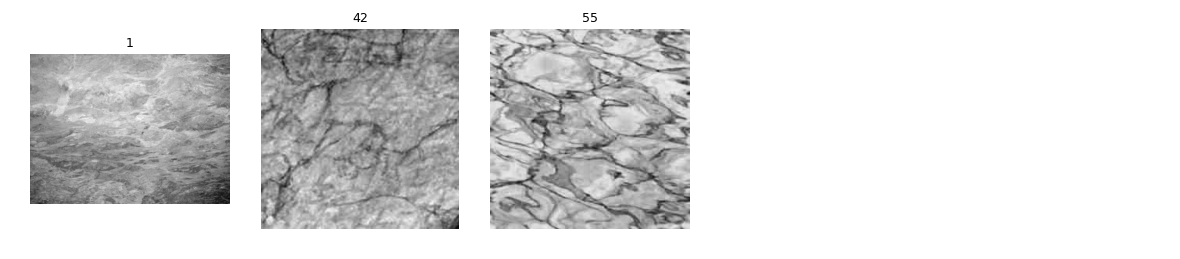

In [263]:
import matplotlib.pyplot as plt
import imageio
import skimage

def normalize_image(img):
    x = skimage.util.img_as_float(img)
    if x.ndim == 2:
        return x
    if x.shape[-1] == 4:
        x = skimage.color.rgba2rgb
    x = skimage.color.rgb2gray(x)
    return x

    x25, x50, x75 = np.percentile(x, [25, 50, 75])
    IQR = x75 - x25
    x = (x - x50) / (6 * IQR)
    return np.clip(x + 0.5, 0.0, 1.0)

def show_texture_grid(df, n_cols=5):
    n_axes = len(df)
    n_rows = int(np.ceil(n_axes / n_cols))
    fig, axes = project.visual.matplotlib.subplot_grid(
        n_rows, n_cols, ax_height=2, ax_width=2, padding=0.3
    )
    axes = np.atleast_1d(axes).ravel()
    for (idx, row), ax in zip(df.iterrows(), axes):
        img = imageio.v2.imread(row.path)
        img = normalize_image(img)
        if row.inverted:
            img = 1 - img
        im = ax.imshow(img, cmap='gray')
        ax.set_title(f'{idx}', fontsize=9)
        ax.axis('off')

    for ax in axes[len(df):]:
        ax.axis('off')

    return fig


for m in props.Material.iloc[1:]:
    textures = textures_by_material[m]
    fig = show_texture_grid(textures)


In [265]:
props['IntensityBias']  = props['DensityKgm3'] - 1000
props['IntensityScale'] = 1000
props

Material DensityKgm3 YoungsModulusPa PoissonRatio Frequency  \
0    Background           0               0            0       0.0   
1     DenseSoft       500.0          1000.0          0.4    0.1875   
2   DenseMedium       500.0          3000.0          0.4     0.375   
3     DenseHard       500.0          9000.0          0.4    0.1875   
4    PorousSoft        50.0          1000.0          0.4    0.0625   
5  PorousMedium        50.0          3000.0          0.4     0.125   
6    PorousHard        50.0          9000.0          0.4    0.0625   

  IntensityBias  IntensityScale  
0         -1000            1000  
1        -500.0            1000  
2        -500.0            1000  
3        -500.0            1000  
4        -950.0            1000  
5        -950.0            1000  
6        -950.0            1000

In [ ]:
def generate_tomographic_image(material_mask, affine):
    I, J, K = material_mask.shape
    T = np.zeros((I, J, K), dtype=np.float32)

    tex_cache = {}
    for m, paths in textures_by_material.items():
        tex_cache[m] = load_textures(paths)

    for k0 in range(0, K, chunk_size):
        k1 = min(k0 + chunk_size, K)
        slab_mask = material_mask[:,:,k0:k1]
        if not np.any(slab_mask):
            continue
        ii, jj, kk = np.mgrid[0:I,0:J,k0:k1]
        ijk = np.stack([ii, jj, kk], axis=-1).reshape(-1, 3)
        xyz = voxel_to_world(ijk, affine)

        slab_flat = slab_mask.reshape(-1)
        for m in np.unique(slab_flat):
            if m == 0: # background
                continue
            sel = (slab_flat == m)
            if not np.any(sel):
                continue
            tex = tex_cache[m]
            tile_mm = 8.0
            tile_m = tile_mm / 1000
            weights = (1/3, 1/3, 1/3)
            pts = xyz_world[sel]
            T_vals = triplanar_points(pts, tex, tile_m, weights)
            T[:,:,k0:k1].reshape(-1)[sel] = T_vals
            

# Signed distance functions

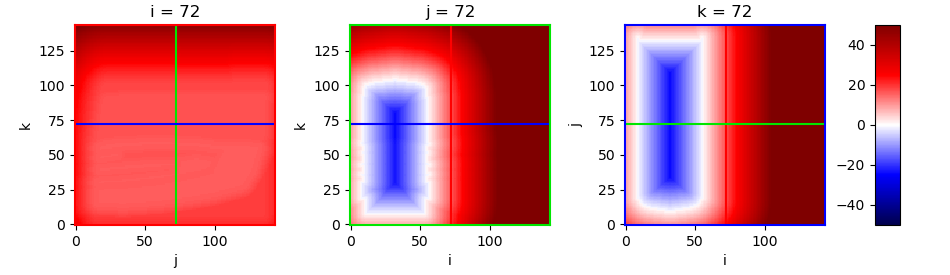

In [50]:
import scipy
def convert_binary_mask_to_sdf(input_mask):
    a = (input_mask != 0)
    d_out = scipy.ndimage.distance_transform_edt(~a)
    d_in  = scipy.ndimage.distance_transform_edt(a)
    return d_out - d_in

sdf_array = convert_binary_mask_to_sdf(padded_array)

fig = project.visual.matplotlib.show_image_slices(sdf_array, cmap='seismic', clim=(-50, 50))

In [51]:
import skimage
def generate_surface_from_sdf(sdf_array, affine, step_size):
    v, f, n, _ = skimage.measure.marching_cubes(sdf_array, level=0, allow_degenerate=False, step_size=step_size)
    v = project.core.transforms.voxel_to_world_coords(v, affine)
    return v, f

v, f = generate_surface_from_sdf(sdf_array, padded_affine, step_size=2)
sdf_mesh = trimesh.Trimesh(vertices=v, faces=f, process=False)
sdf_mesh.is_watertight

True

In [52]:
p = pv.Plotter()
p.add_mesh(pv.wrap(sdf_mesh), color='blue', opacity=0.5, show_edges=True)
p.enable_depth_peeling(10)
p.show(jupyter_backend='trame')

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14bed798df90_10" src="https://ondemand.bridges2.…

In [339]:
labels, counts = np.unique(output_array, return_counts=True)
pprint(counts)

opacity = np.zeros(9, dtype=float)
opacity[labels] = np.minimum(25000 / counts, 1.0)
opacity[0] = 0
pprint(opacity)

ndarray(shape=(4,), dtype=int64)
├── 0: np.int64(1567366)
├── 1: np.int64(95970)
├── 2: np.int64(212257)
└── 3: np.int64(221559)
ndarray(shape=(9,), dtype=float64)
├── 0: np.float64(0.0)
├── 1: np.float64(0.26049807231426486)
├── 2: np.float64(0.11778174571392228)
├── 3: np.float64(0.11283676131414205)
├── 4: np.float64(0.0)
├── 5: np.float64(0.0)
├── 6: np.float64(0.0)
├── 7: np.float64(0.0)
└── 8: np.float64(0.0)


In [341]:
pv_grid = pv.ImageData(
    dimensions=bin_array.shape,
    spacing=np.linalg.norm(affine[:3,:3], axis=1),
    origin=affine[:3,3]
)
pv_grid.point_data['mask'] = bin_array.flatten(order='F').astype(int)
pv_grid.point_data['label'] = output_array.flatten(order='F').astype(int)

p = pv.Plotter()
p.add_volume(
    pv_grid,
    scalars='label',
    cmap='jet',
    clim=(0, 8),
    opacity=opacity
)
p.enable_depth_peeling(10)
p.show()

Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x154c39c22c10_72" src="https://ondemand.bridges2.…